## Linking a dataset of real historical persons 

In this example, we deduplicate a more realistic dataset.  The data is based on historical persons scraped from wikidata.  Duplicate records are introduced with a variety of errors introduced.

In [1]:
from splink.duckdb.duckdb_linker import DuckDBLinker
import altair as alt
alt.renderers.enable('mimetype')

import pandas as pd 
pd.options.display.max_rows = 1000
df = pd.read_parquet("./data/historical_figures_with_errors_50k.parquet")

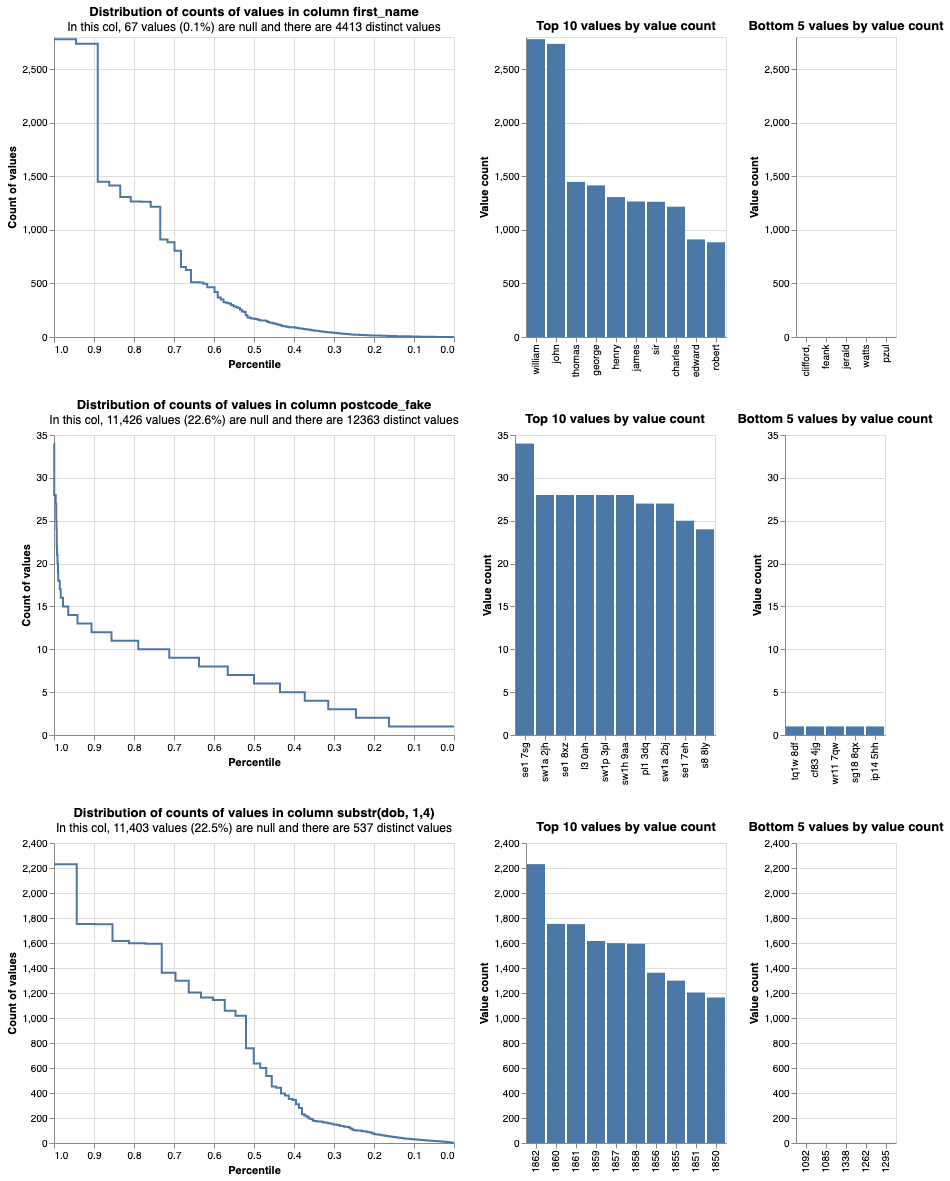

In [2]:
# Simple settings dictionary will be used for exploratory analysis
settings = {
    "link_type": "dedupe_only",
    "blocking_rules_to_generate_predictions": [
        "l.first_name = r.first_name and l.surname = r.surname",
        "l.surname = r.surname and l.dob = r.dob",
        "l.first_name = r.first_name and l.dob = r.dob",
        "l.postcode_fake = r.postcode_fake and l.first_name = r.first_name",
    ],
}
linker = DuckDBLinker(df, settings)

linker.profile_columns(
    ["first_name", "postcode_fake", "substr(dob, 1,4)"], top_n=10, bottom_n=5
)

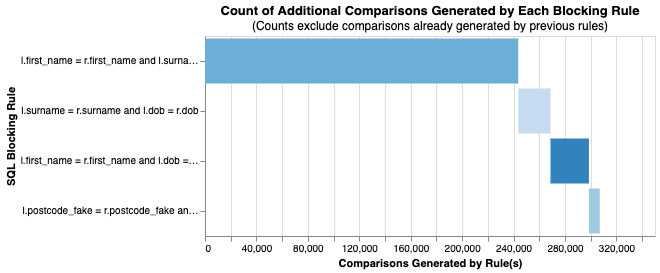

In [3]:
linker.cumulative_num_comparisons_from_blocking_rules_chart()

In [4]:
import splink.duckdb.duckdb_comparison_library as cl

settings = {
    "link_type": "dedupe_only",
    "blocking_rules_to_generate_predictions": [
        "l.first_name = r.first_name and l.surname = r.surname",
        "l.surname = r.surname and l.dob = r.dob",
        "l.first_name = r.first_name and l.dob = r.dob",
        "l.postcode_fake = r.postcode_fake and l.first_name = r.first_name",
    ],
    "comparisons": [
        cl.jaro_winkler_at_thresholds("first_name", [0.9, 0.7], term_frequency_adjustments=True),
        cl.jaro_winkler_at_thresholds("surname", [0.9, 0.7], term_frequency_adjustments=True),
        cl.levenshtein_at_thresholds("dob", [1,2], term_frequency_adjustments=True),
        cl.levenshtein_at_thresholds("postcode_fake", 2,term_frequency_adjustments=True),
        cl.exact_match("birth_place", term_frequency_adjustments=True),
        cl.exact_match("occupation",  term_frequency_adjustments=True),
    ],
    "retain_matching_columns": True,
    "retain_intermediate_calculation_columns": True,
    "max_iterations": 10,
    "em_convergence": 0.01
}

linker = DuckDBLinker(df, settings, connection=":temporary:")

In [5]:
linker.estimate_probability_two_random_records_match(
    [
        "l.first_name = r.first_name and l.surname = r.surname and l.dob = r.dob",
        "substr(l.first_name,1,2) = substr(r.first_name,1,2) and l.surname = r.surname and substr(l.postcode_fake,1,2) = substr(r.postcode_fake,1,2)",
        "l.dob = r.dob and l.postcode_fake = r.postcode_fake",
    ],
    recall=0.6,
)

Probability two random records match is estimated to be  0.000136.
This means that amongst all possible pairwise record comparisons, one in 7,362.31 are expected to match.  With 1,279,041,753 total possible comparisons, we expect a total of around 173,728.33 matching pairs


In [6]:
linker.estimate_u_using_random_sampling(max_pairs=5e6)

----- Estimating u probabilities using random sampling -----

Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - first_name (no m values are trained).
    - surname (no m values are trained).
    - dob (no m values are trained).
    - postcode_fake (no m values are trained).
    - birth_place (no m values are trained).
    - occupation (no m values are trained).


In [7]:
blocking_rule = "l.first_name = r.first_name and l.surname = r.surname"
training_session_names = linker.estimate_parameters_using_expectation_maximisation(blocking_rule)


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.first_name = r.first_name and l.surname = r.surname

Parameter estimates will be made for the following comparison(s):
    - dob
    - postcode_fake
    - birth_place
    - occupation

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - first_name
    - surname

Iteration 1: Largest change in params was -0.524 in probability_two_random_records_match
Iteration 2: Largest change in params was -0.0339 in probability_two_random_records_match
Iteration 3: Largest change in params was 0.0119 in the m_probability of birth_place, level `Exact match`
Iteration 4: Largest change in params was 0.00374 in the m_probability of birth_place, level `Exact match`

EM converged after 4 iterations

Your model is not yet fully trained. Missing estimates for:
    - first_name (no m values are trained).
    - surname (no m values are traine

In [8]:
blocking_rule = "l.dob = r.dob"
training_session_dob = linker.estimate_parameters_using_expectation_maximisation(blocking_rule)


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.dob = r.dob

Parameter estimates will be made for the following comparison(s):
    - first_name
    - surname
    - postcode_fake
    - birth_place
    - occupation

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - dob

Iteration 1: Largest change in params was -0.362 in the m_probability of first_name, level `Exact match`
Iteration 2: Largest change in params was -0.0302 in the m_probability of first_name, level `Exact match`
Iteration 3: Largest change in params was 0.00453 in the m_probability of first_name, level `All other comparisons`

EM converged after 3 iterations

Your model is fully trained. All comparisons have at least one estimate for their m and u values


The final match weights can be viewed in the match weights chart:

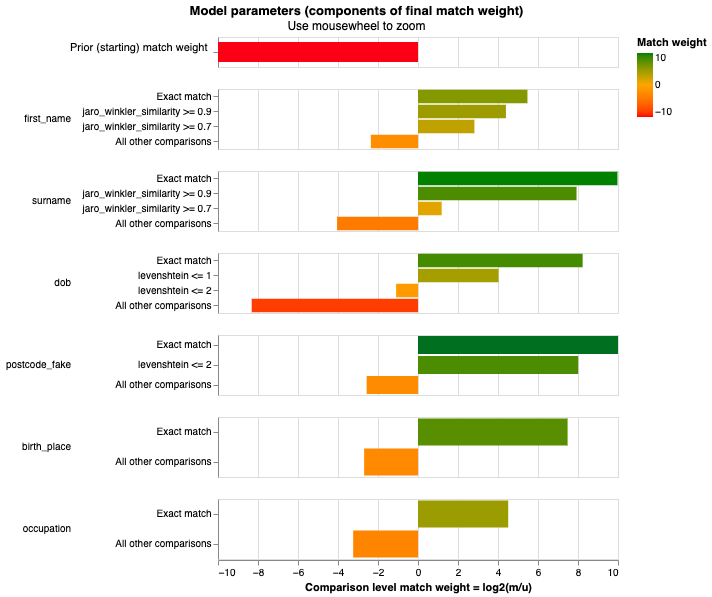

In [9]:
linker.match_weights_chart()

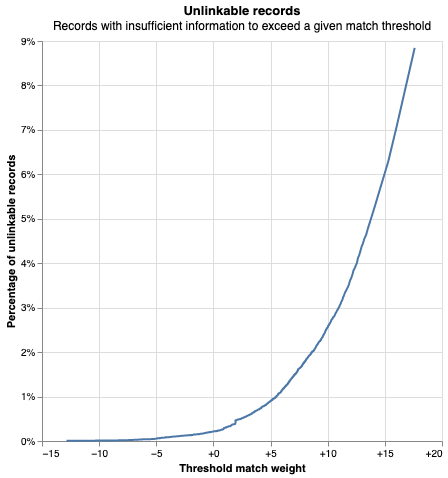

In [10]:
linker.unlinkables_chart()

In [11]:
df_predict = linker.predict()
df_e = df_predict.as_pandas_dataframe(limit=5)
df_e

,match_weight,match_probability,unique_id_l,unique_id_r,first_name_l,first_name_r,gamma_first_name,tf_first_name_l,tf_first_name_r,bf_first_name,...,bf_birth_place,bf_tf_adj_birth_place,occupation_l,occupation_r,gamma_occupation,tf_occupation_l,tf_occupation_r,bf_occupation,bf_tf_adj_occupation,match_key
0,18.131419,0.999997,Q2296770-1,Q2296770-14,thomas,thomas,3,0.028667,0.028667,44.380695,...,1.000000,1.000000,politician,politician,1,0.088932,0.088932,22.786409,0.443341,0
1,40.311237,1.000000,Q1443188-1,Q1443188-3,frank,frank,3,0.006335,0.006335,44.380695,...,0.154553,1.000000,liturgist,liturgist,1,0.000237,0.000237,22.786409,166.178966,0
2,40.311237,1.000000,Q1443188-2,Q1443188-3,frank,frank,3,0.006335,0.006335,44.380695,...,0.154553,1.000000,liturgist,liturgist,1,0.000237,0.000237,22.786409,166.178966,0
3,41.258395,1.000000,Q90404618-1,Q90404618-3,emlie,emlie,3,0.000099,0.000099,44.380695,...,178.565257,4.701184,playwright,playwright,1,0.002728,0.002728,22.786409,14.450345,0
4,41.258395,1.000000,Q90404618-2,Q90404618-3,emlie,emlie,3,0.000099,0.000099,44.380695,...,178.565257,4.701184,playwright,playwright,1,0.002728,0.002728,22.786409,14.450345,0


You can also view rows in this dataset as a waterfall chart as follows:

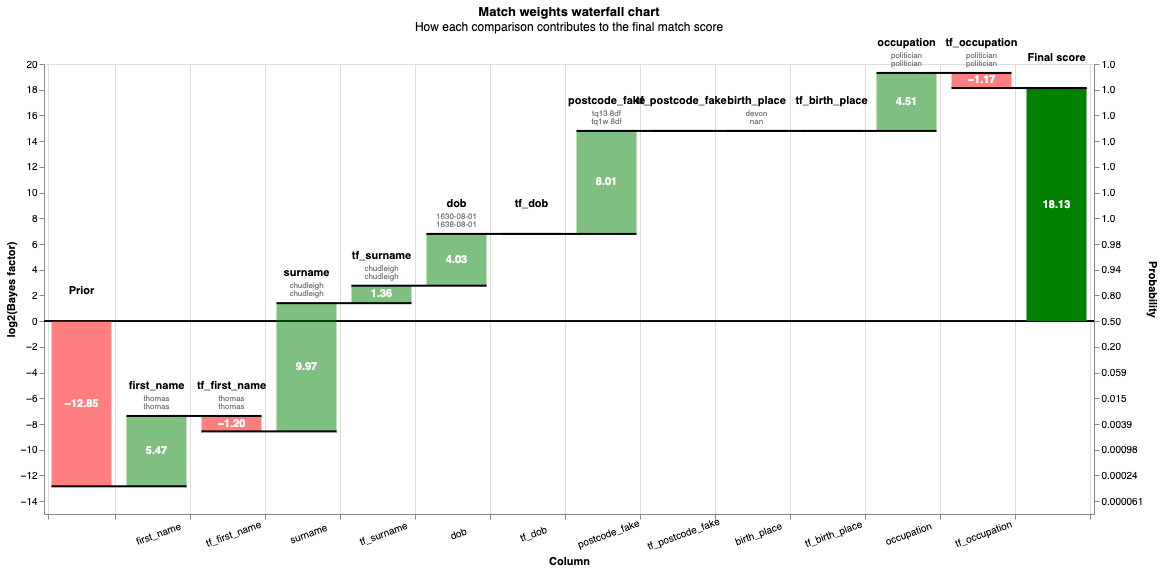

In [12]:
from splink.charts import waterfall_chart
records_to_plot = df_e.to_dict(orient="records")
linker.waterfall_chart(records_to_plot, filter_nulls=False)

In [13]:
clusters = linker.cluster_pairwise_predictions_at_threshold(df_predict, threshold_match_probability=0.95)

Completed iteration 1, root rows count 638
Completed iteration 2, root rows count 122
Completed iteration 3, root rows count 35
Completed iteration 4, root rows count 6
Completed iteration 5, root rows count 0


In [14]:
linker.cluster_studio_dashboard(df_predict, clusters, "50k_cluster.html", sampling_method='by_cluster_size', overwrite=True)

from IPython.display import IFrame

IFrame(
    src="./50k_cluster.html", width="100%", height=1200
)  

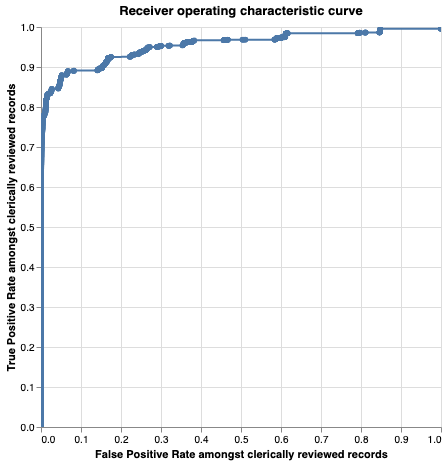

In [15]:
linker.roc_chart_from_labels_column("cluster",match_weight_round_to_nearest=0.02)

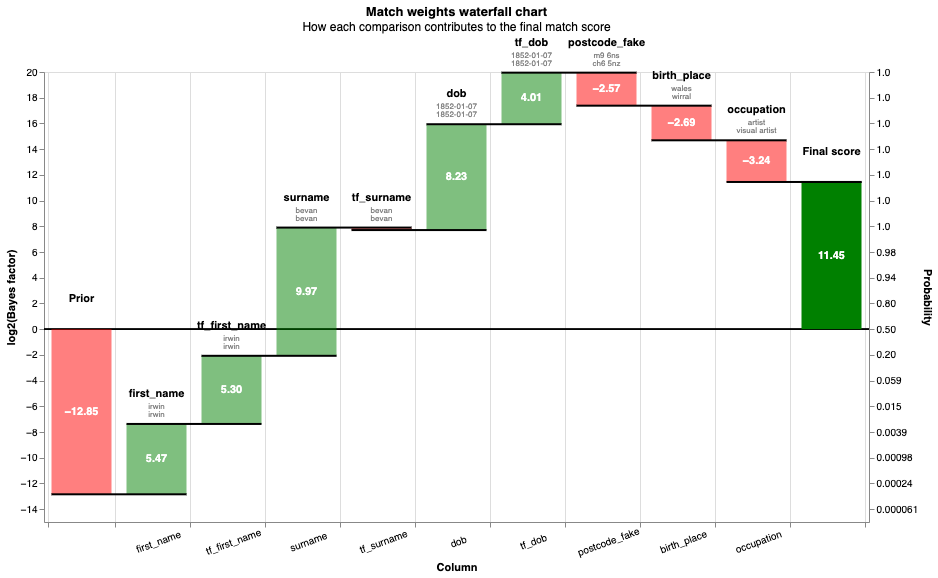

In [16]:
records = linker.prediction_errors_from_labels_column(
    "cluster",
    threshold=0.999,
    include_false_negatives=False,
    include_false_positives=True,
).as_record_dict()
linker.waterfall_chart(records)

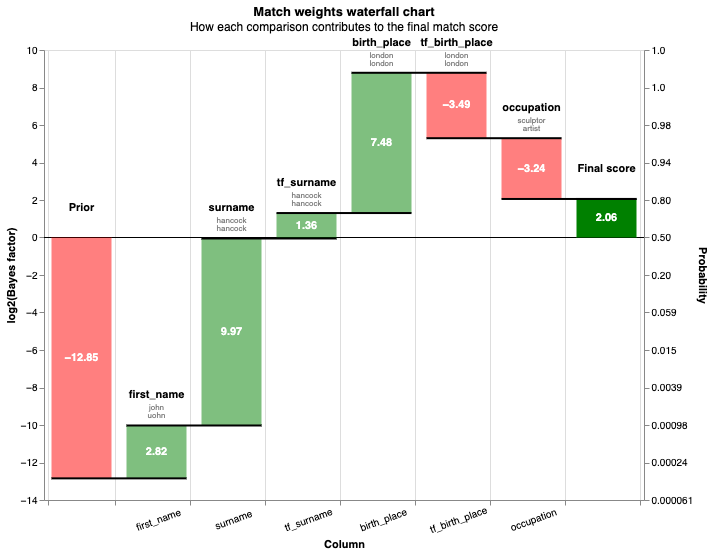

In [17]:
# Some of the false negatives will be because they weren't detected by the blocking rules
records = linker.prediction_errors_from_labels_column(
    "cluster",
    threshold=0.5,
    include_false_negatives=True,
    include_false_positives=False,
).as_record_dict(limit=50)

linker.waterfall_chart(records)